## Hyperspectral Image Segmentation by Convolutional Neural Network 

### Binned spectra (424, 283, 212, 170, 142, 122, 106, 85, 53, 22, 15)
### with spatial dimension included

### training on each image separately

---

In [1]:
# -- here are functions that generate a class that memory maps the raw data 
#    cube.  After executing this cell, the syntax is:
#    fname = "[path to data]/foo.raw"
#    cube = read_hyper(fname)

import os
import numpy as np

def read_header(hdrfile, verbose=True):
    """
    Read a Middleton header file.

    Parameters
    ----------
    hdrfile : str
        Name of header file.
    verbose : bool, optional
        If True, alert the user.

    Returns
    -------
    dict : dict
        A dictionary continaing the number of rows, columns, and wavelengths
        as well as an array of band centers.
    """

    # -- alert
    if verbose:
        print("reading and parsing {0}...".format(hdrfile))

    # -- open the file and read in the records
    recs = [rec for rec in open(hdrfile)]

    # -- parse for samples, lines, bands, and the start of the wavelengths
    for irec, rec in enumerate(recs):
        if 'samples' in rec:
            samples = int(rec.split("=")[1])
        elif 'lines' in rec:
            lines = int(rec.split("=")[1])
        elif 'bands' in rec:
            bands = int(rec.split("=")[1])
        elif "Wavelength" in rec:
            w0ind = irec+1

    # -- parse for the wavelengths
    waves = np.array([float(rec.split(",")[0]) for rec in 
                      recs[w0ind:w0ind+bands]])

    # -- return a dictionary
    return {"nrow":samples, "ncol":lines, "nwav":bands, "waves":waves}


def read_raw(rawfile, shape, hyper=False, verbose=True):
    """
    Read a Middleton raw file.

    Parameters
    ----------
    rawfile : str
        The name of the raw file.
    shape : tuple
        The output shape of the data cube (nwav, nrow, ncol).
    hyper : bool, optional
        Set this flag to read a hyperspectral image.
    verbose : bool, optional
        Alert the user.

    Returns
    -------
    memmap : memmap
        A numpy memmap of the datacube.
    """

    # -- alert
    if verbose:
        print("reading {0}...".format(rawfile))

    # -- read either broadband or hyperspectral image
    if hyper:
        return np.memmap(rawfile, np.uint16, mode="r") \
            .reshape(shape[2], shape[0], shape[1])[:, :, ::-1] \
            .transpose(1, 2, 0)
    else:
        return np.memmap(rawfile, np.uint8, mode="r") \
            .reshape(shape[1], shape[2], shape[0])[:, :, ::-1]


def read_hyper(fpath, fname=None, full=True):
    """
    Read a full hyperspectral scan (raw and header file).

    Parameters
    ----------
    fpath : str
        Either the full name+path of the raw file or the path of the raw file.
        If the latter, fname must be supplied.
    fname : str, optional
        The name of the raw file (required if fpath is set to a path).
    full : bool, optional
        If True, output a class containing data and supplementary information.
        If False, output only the data.

    Returns
    -------
    output or memmap : class or memmap
        If full is True, a class containing data plus supplementary 
        information.  If full is False, a memmap array of the data.
    """

    # -- set up the file names
    if fname is not None:
        fpath = os.path.join(fpath, fname)

    # -- read the header
    hdr = read_header(fpath.replace("raw", "hdr"))
    sh  = (hdr["nwav"], hdr["nrow"], hdr["ncol"])

    # -- if desired, only output data cube
    if not full:
        return read_raw(fpath, sh, hyper=True)

    # -- output full structure
    class output():
        def __init__(self, fpath):
            self.filename = fpath
            self.data     = read_raw(fpath, sh, hyper=True)
            self.waves    = hdr["waves"]
            self.nwav     = sh[0]
            self.nrow     = sh[1]
            self.ncol     = sh[2]

    return output(fpath)

In [2]:
def kmeans_test_dictionary(labels, test, k):
    import collections, numpy
    
    unique_test, counts_test = numpy.unique(labels[test[:,0], test[:,1]], return_counts=True)
    counts_test_norm = (counts_test/test.shape[0])*100
    test_dict = dict(zip(unique_test, counts_test))
    test_dict_norm = dict(zip(unique_test, counts_test_norm))
    
    for i in range(0, k):
        if test_dict.get(i) is None: test_dict[i] = 0
        if test_dict_norm.get(i) is None: test_dict_norm[i] = 0
    
    return test_dict, test_dict_norm

In [3]:
def kmeans_test_dataframe(sky_dict,
                          clouds_dict,
                          veg_dict,
                          wtr_dict,
                          blt_dict,
                          windows_dict,
                          rds_dict,
                          cars_dict,
                          mtl_dict
                         ):
    import pandas as pd
    
    pixel_names = ['sky', 'clouds', 'vegetation', 'water', 'built',
                  'windows', 'roads', 'cars', 'metal']
    df_test = pd.DataFrame([sky_dict,
                            clouds_dict,
                            veg_dict,
                            wtr_dict,
                            blt_dict,
                            windows_dict,
                            rds_dict,
                            cars_dict,
                            mtl_dict], index=pixel_names)
    df_test = df_test.transpose()
    
    return df_test

In [4]:
def plot_confusion_matrix(df_test, norm=True):
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    cm = np.array([df_test['sky'].values,
                   df_test['clouds'].values,
                   df_test['vegetation'].values,
                   df_test['water'].values,
                   df_test['built'].values,
                   df_test['windows'].values,
                   df_test['roads'].values,
                   df_test['cars'].values,
                   df_test['metal'].values])
    classes = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 
              'cars', 'metal']
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    if norm:
        title='Normalized Confusion Matrix'
        fmt='.2f'
    else:
        title='Confusion Matrix'
        fmt='d'
    ax.set(xticks=np.arange(cm.shape[1]),
          yticks=np.arange(cm.shape[0]),
          xticklabels=np.arange(0,cm.shape[1]).astype(str), 
          yticklabels=classes,
          title=title,
          ylabel='True Label',
          xlabel='Predicted Label')
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #        rotation_mode="anchor")
    thresh = cm.max()/2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], fmt),
                   ha="center", va="center",
                   color="white" if cm[i,j] > thresh else "black")
    fig.tight_layout()
    plt.show()

In [5]:
def plot_test_result(df_Test):
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    df_test = df_Test.transpose()
    ax = df_test.plot.bar(rot=0, stacked=True, colormap='tab20b')
                          #color=['tab:blue', 'tab:green', 'tab:gray'])
    plt.xlabel('Actual Class')
    plt.ylabel('%of Test Pixels')
    plt.title('Error in Prediction')
    plt.legend(bbox_to_anchor=(1,1), loc=2, borderaxespad=1.0, prop={'size':11})
    plt.show()

In [6]:
def point_from_string(text):
    
    items = text.strip("\n").split(" ")
    rind = int(items[0])
    cind = int(items[1])
    
    return rind, cind

In [7]:
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

In [8]:
def read_labelled_coordinates(kind, scan):
    file = open("../manual_classified_pixels/{0}_coordinates_{1}.txt".format(kind, scan), "r")
    coords = file.readlines()
    file.close()
    coords = np.array([point_from_string(line) for line in coords])
    print("{0}: {1}".format(kind,coords.shape))
    
    return coords

In [9]:
import random

def split_train_test_indices(coords, seed, trrat, kind):
    ind = np.arange(coords.shape[0])
    random.Random(seed).shuffle(ind)
    lim_ind = int(len(ind)*trrat)
    train_ind = ind[:lim_ind]
    test_ind = ind[lim_ind:]
    
    print("{0}: {1} {2}".format(kind, len(train_ind), len(test_ind)))
    
    return train_ind, test_ind

In [10]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def CNN_Model(nwaves, filtersize):
    Inputs_1 = keras.Input(shape=(nwaves, 1), name="spectra")
    Conv1D_1 = layers.Conv1D(16, kernel_size=(filtersize), padding="same", activation="relu")(Inputs_1)
    MaxPool_1 = layers.MaxPooling1D((2), strides=2)(Conv1D_1)
    Conv1D_2 = layers.Conv1D(32, kernel_size=(filtersize), padding="same", activation="relu")(MaxPool_1)
    MaxPool_2 = layers.MaxPooling1D((2), strides=2)(Conv1D_2)
    Dropout_1 = layers.Dropout(0.5)(MaxPool_2)
    Flatten_1 = layers.Flatten()(Dropout_1)

    Inputs_2 = keras.Input(shape=(2,), name="spatial")
    Concat = layers.concatenate([Flatten_1, Inputs_2])
    Dense_1 = layers.Dense(512, activation="relu")(Concat)
    Output = layers.Dense(9, activation="softmax")(Dense_1)

    model = keras.Model(inputs=[Inputs_1, Inputs_2],
                        outputs=[Output],)
    
    return model

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_history(model):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12, 10))
    ax1.plot(model.history['loss'])
    ax1.plot(model.history['val_loss'])
    ax1.set_title('CNN Model Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.locator_params(nbins=13, axis='x')
    ax1.legend(['train', 'test'], loc='center right')
    ax2.plot(model.history['accuracy'])
    ax2.plot(model.history['val_accuracy'])
    ax2.set_title('CNN Model Accuracy')
    ax2.set_ylabel('accuracy')
    ax2.set_xlabel('epoch')
    ax2.locator_params(nbins=12, axis='x')
    ax2.legend(['train', 'test'], loc='center right')
    ax3.plot(model.history['loss'])
    ax3.plot(model.history['val_loss'])
    ax3.set_ylabel('log(loss)')
    ax3.set_xlabel('epoch')
    ax3.locator_params(nbins=13, axis='x')
    ax3.legend(['train', 'test'], loc='center right')
    ax3.set_yscale('log')
    ax4.plot(model.history['accuracy'])
    ax4.plot(model.history['val_accuracy'])
    ax4.set_ylabel('log(accuracy)')
    ax4.set_xlabel('epoch')
    ax4.locator_params(nbins=12, axis='x')
    ax4.legend(['train', 'test'], loc='center right')
    ax4.set_yscale('log')
    plt.show()

---
### Classes:
1. Sky
2. Clouds
3. Water
4. Vegetation
5. Buildings (concrete structures)
6. Windows
7. Roads
8. Cars
9. Metal Structures
---


## CNN on veg_00108 (South Facing @ ~2pm)

In [12]:
fname = "../../image_files/veg_00108.raw"
cube = read_hyper(fname)

reading and parsing ../../image_files/veg_00108.hdr...
reading ../../image_files/veg_00108.raw...


In [13]:
cube_sub = cube.data[:, :, :].astype(float)
print(cube_sub.shape)

(848, 1600, 1600)


In [14]:
cube_reshaped = cube_sub.transpose(1, 2, 0).reshape((cube_sub.shape[1] * cube_sub.shape[2]), cube_sub.shape[0])
print(cube_reshaped.shape)

(2560000, 848)


In [546]:
cube_standard = (cube_reshaped - cube_reshaped.mean(1, keepdims=True)) / cube_reshaped.std(1, keepdims=True)
print(cube_standard.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [16]:
sky_coords = read_labelled_coordinates("1_sky", "108")
clouds_coords = read_labelled_coordinates("2_clouds", "108")
veg_coords = read_labelled_coordinates("3_vegetation", "108")
wtr_coords = read_labelled_coordinates("4_water", "108")
blt_coords = read_labelled_coordinates("5_buildings", "108")
windows_coords = read_labelled_coordinates("6_windows", "108")
rds_coords = read_labelled_coordinates("7_roads", "108")
cars_coords = read_labelled_coordinates("8_cars", "108")
mtl_coords = read_labelled_coordinates("9_metal", "108")

1_sky: (300, 2)
2_clouds: (500, 2)
3_vegetation: (600, 2)
4_water: (50, 2)
5_buildings: (1020, 2)
6_windows: (500, 2)
7_roads: (30, 2)
8_cars: (100, 2)
9_metal: (100, 2)


In [17]:
# create position array and normalize

xy = coords(cube_sub.shape[1], cube_sub.shape[2])
xy = xy/xy.max()

### Bin Spectra

In [547]:
num_of_bins = 106
filtersize = 6
bin_ind = []

for i in range(0, num_of_bins):
    low_ind = int(i*int(cube_sub.shape[0]/num_of_bins))
    upp_ind = int(low_ind + int(cube_sub.shape[0]/num_of_bins))
    bin_ind.append([low_ind, upp_ind])
bin_ind[-1][-1] = cube_sub.shape[0]

print(len(bin_ind))
print(bin_ind)

106
[[0, 8], [8, 16], [16, 24], [24, 32], [32, 40], [40, 48], [48, 56], [56, 64], [64, 72], [72, 80], [80, 88], [88, 96], [96, 104], [104, 112], [112, 120], [120, 128], [128, 136], [136, 144], [144, 152], [152, 160], [160, 168], [168, 176], [176, 184], [184, 192], [192, 200], [200, 208], [208, 216], [216, 224], [224, 232], [232, 240], [240, 248], [248, 256], [256, 264], [264, 272], [272, 280], [280, 288], [288, 296], [296, 304], [304, 312], [312, 320], [320, 328], [328, 336], [336, 344], [344, 352], [352, 360], [360, 368], [368, 376], [376, 384], [384, 392], [392, 400], [400, 408], [408, 416], [416, 424], [424, 432], [432, 440], [440, 448], [448, 456], [456, 464], [464, 472], [472, 480], [480, 488], [488, 496], [496, 504], [504, 512], [512, 520], [520, 528], [528, 536], [536, 544], [544, 552], [552, 560], [560, 568], [568, 576], [576, 584], [584, 592], [592, 600], [600, 608], [608, 616], [616, 624], [624, 632], [632, 640], [640, 648], [648, 656], [656, 664], [664, 672], [672, 680], [68

In [548]:
cube_binned = np.zeros(shape=(cube_standard.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned[:, i] = cube_standard[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned.shape)

(2560000, 106)


In [549]:
cube_standard = cube_binned
print(cube_standard.shape)

(2560000, 106)


#### split classified pixels into 80% training and 20% testing sets

In [550]:
trrat = 0.8
sky_train_ind, sky_test_ind = split_train_test_indices(sky_coords, 0, trrat, "sky")
clouds_train_ind, clouds_test_ind = split_train_test_indices(clouds_coords, 1, trrat, "clouds")
veg_train_ind, veg_test_ind = split_train_test_indices(veg_coords, 2, trrat, "veg")
wtr_train_ind, wtr_test_ind = split_train_test_indices(wtr_coords, 3, trrat, "wtr")
blt_train_ind, blt_test_ind = split_train_test_indices(blt_coords, 4, trrat, "blt")
windows_train_ind, windows_test_ind = split_train_test_indices(windows_coords, 5, trrat, "windows")
rds_train_ind, rds_test_ind = split_train_test_indices(rds_coords, 6, trrat, "rds")
cars_train_ind, cars_test_ind = split_train_test_indices(cars_coords, 7, trrat, "cars")
mtl_train_ind, mtl_test_ind = split_train_test_indices(mtl_coords, 8, trrat, "mtl")

sky: 240 60
clouds: 400 100
veg: 480 120
wtr: 40 10
blt: 816 204
windows: 400 100
rds: 24 6
cars: 80 20
mtl: 80 20


In [551]:
cube_std_3d = cube_standard.reshape(cube_sub.shape[1], cube_sub.shape[2], num_of_bins)
print(cube_std_3d.shape)
print(xy.shape)

(1600, 1600, 106)
(1600, 1600, 2)


In [552]:
cube_sky_train = cube_std_3d[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
cube_sky_test = cube_std_3d[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
sky_xy_train = xy[sky_coords[sky_train_ind[:], 0], sky_coords[sky_train_ind[:], 1], :]
sky_xy_test = xy[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1], :]
print("sky ", cube_sky_train.shape, cube_sky_test.shape)

cube_clouds_train = cube_std_3d[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
cube_clouds_test = cube_std_3d[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
clouds_xy_train = xy[clouds_coords[clouds_train_ind[:], 0], clouds_coords[clouds_train_ind[:], 1], :]
clouds_xy_test = xy[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:], 1], :]
print("clouds ", cube_clouds_train.shape, cube_clouds_test.shape)

cube_veg_train = cube_std_3d[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
cube_veg_test = cube_std_3d[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
veg_xy_train = xy[veg_coords[veg_train_ind[:], 0], veg_coords[veg_train_ind[:], 1], :]
veg_xy_test = xy[veg_coords[veg_test_ind[:], 0], veg_coords[veg_test_ind[:], 1], :]
print("vegetation ", cube_veg_train.shape, cube_veg_test.shape)

cube_wtr_train = cube_std_3d[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
cube_wtr_test = cube_std_3d[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
wtr_xy_train = xy[wtr_coords[wtr_train_ind[:], 0], wtr_coords[wtr_train_ind[:], 1], :]
wtr_xy_test = xy[wtr_coords[wtr_test_ind[:], 0], wtr_coords[wtr_test_ind[:], 1], :]
print("water ", cube_wtr_train.shape, cube_wtr_test.shape)

cube_blt_train = cube_std_3d[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
cube_blt_test = cube_std_3d[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
blt_xy_train = xy[blt_coords[blt_train_ind[:], 0], blt_coords[blt_train_ind[:], 1], :]
blt_xy_test = xy[blt_coords[blt_test_ind[:], 0], blt_coords[blt_test_ind[:], 1], :]
print("built ", cube_blt_train.shape, cube_blt_test.shape)

cube_windows_train = cube_std_3d[windows_coords[windows_train_ind[:],0], windows_coords[windows_train_ind[:],1],:]
cube_windows_test = cube_std_3d[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
windows_xy_train = xy[windows_coords[windows_train_ind[:], 0], windows_coords[windows_train_ind[:], 1], :]
windows_xy_test = xy[windows_coords[windows_test_ind[:], 0], windows_coords[windows_test_ind[:], 1], :]
print("windows ", cube_windows_train.shape, cube_windows_test.shape)

cube_rds_train = cube_std_3d[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
cube_rds_test = cube_std_3d[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
rds_xy_train = xy[rds_coords[rds_train_ind[:], 0], rds_coords[rds_train_ind[:], 1], :]
rds_xy_test = xy[rds_coords[rds_test_ind[:], 0], rds_coords[rds_test_ind[:], 1], :]
print("roads ", cube_rds_train.shape, cube_rds_test.shape)

cube_cars_train = cube_std_3d[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cube_cars_test = cube_std_3d[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
cars_xy_train = xy[cars_coords[cars_train_ind[:], 0], cars_coords[cars_train_ind[:], 1], :]
cars_xy_test = xy[cars_coords[cars_test_ind[:], 0], cars_coords[cars_test_ind[:], 1], :]
print("cars ", cube_cars_train.shape, cube_cars_test.shape)

cube_mtl_train = cube_std_3d[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
cube_mtl_test = cube_std_3d[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
mtl_xy_train = xy[mtl_coords[mtl_train_ind[:], 0], mtl_coords[mtl_train_ind[:], 1], :]
mtl_xy_test = xy[mtl_coords[mtl_test_ind[:], 0], mtl_coords[mtl_test_ind[:], 1], :]
print("metal ", cube_mtl_train.shape, cube_mtl_test.shape)

sky  (240, 106) (60, 106)
clouds  (400, 106) (100, 106)
vegetation  (480, 106) (120, 106)
water  (40, 106) (10, 106)
built  (816, 106) (204, 106)
windows  (400, 106) (100, 106)
roads  (24, 106) (6, 106)
cars  (80, 106) (20, 106)
metal  (80, 106) (20, 106)


In [553]:
# concatenate training and testing sets and create index arrays

cube_train = np.concatenate((cube_sky_train, cube_clouds_train, cube_veg_train, cube_wtr_train, cube_blt_train,
                            cube_windows_train, cube_rds_train, cube_cars_train, cube_mtl_train), axis=0)
cube_train_labels = [0]*cube_sky_train.shape[0] + [1]*cube_clouds_train.shape[0] \
                    + [2]*cube_veg_train.shape[0] + [3]*cube_wtr_train.shape[0] \
                    + [4]*cube_blt_train.shape[0] + [5]*cube_windows_train.shape[0] \
                    + [6]*cube_rds_train.shape[0] + [7]*cube_cars_train.shape[0] + [8]*cube_mtl_train.shape[0]
xy_train = np.concatenate((sky_xy_train, clouds_xy_train, veg_xy_train, wtr_xy_train, blt_xy_train,
                             windows_xy_train, rds_xy_train, cars_xy_train, mtl_xy_train), axis=0)

cube_test = np.concatenate((cube_sky_test, cube_clouds_test, cube_veg_test, cube_wtr_test, cube_blt_test,
                            cube_windows_test, cube_rds_test, cube_cars_test, cube_mtl_test), axis=0)
cube_test_labels = [0]*cube_sky_test.shape[0] + [1]*cube_clouds_test.shape[0] \
                    + [2]*cube_veg_test.shape[0] + [3]*cube_wtr_test.shape[0] \
                    + [4]*cube_blt_test.shape[0] + [5]*cube_windows_test.shape[0] \
                    + [6]*cube_rds_test.shape[0] + [7]*cube_cars_test.shape[0] + [8]*cube_mtl_test.shape[0]
xy_test = np.concatenate((sky_xy_test, clouds_xy_test, veg_xy_test, wtr_xy_test, blt_xy_test,
                             windows_xy_test, rds_xy_test, cars_xy_test, mtl_xy_test), axis=0)

In [554]:
cube_train_labels = np.array(cube_train_labels)
cube_test_labels = np.array(cube_test_labels)

print(cube_train.shape, cube_train_labels.shape, xy_train.shape)
print(cube_test.shape, cube_test_labels.shape, xy_test.shape)

(2560, 106) (2560,) (2560, 2)
(640, 106) (640,) (640, 2)


### Train CNN

In [555]:
cnn = CNN_Model(cube_std_3d.shape[2], filtersize)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [556]:
#keras.utils.plot_model(cnn, show_shapes=True)
#cnn.summary()

cube_train2 = cube_train.reshape(cube_train.shape[0], cube_train.shape[1], 1)
cube_test2 = cube_test.reshape(cube_test.shape[0], cube_test.shape[1], 1)

In [557]:
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=200, batch_size=512)

Epoch 1/200
5/5 [==============================] - 1s 153ms/step - loss: 1.8353 - accuracy: 0.3887 - val_loss: 1.4631 - val_accuracy: 0.4938
Epoch 2/200
5/5 [==============================] - 0s 44ms/step - loss: 1.3552 - accuracy: 0.5785 - val_loss: 1.1396 - val_accuracy: 0.7031
Epoch 3/200
5/5 [==============================] - 0s 54ms/step - loss: 1.0795 - accuracy: 0.6762 - val_loss: 0.8975 - val_accuracy: 0.7188
Epoch 4/200
5/5 [==============================] - 0s 42ms/step - loss: 0.9047 - accuracy: 0.6977 - val_loss: 0.7789 - val_accuracy: 0.7328
Epoch 5/200
5/5 [==============================] - 0s 46ms/step - loss: 0.8089 - accuracy: 0.7418 - val_loss: 0.7263 - val_accuracy: 0.8094
Epoch 6/200
5/5 [==============================] - 0s 58ms/step - loss: 0.7639 - accuracy: 0.7691 - val_loss: 0.6809 - val_accuracy: 0.8000
Epoch 7/200
5/5 [==============================] - 0s 43ms/step - loss: 0.7311 - accuracy: 0.7727 - val_loss: 0.6482 - val_accuracy: 0.8156
Epoch 8/200
5/5 [==

5/5 [==============================] - 0s 36ms/step - loss: 0.1830 - accuracy: 0.9391 - val_loss: 0.1743 - val_accuracy: 0.9281
Epoch 118/200
5/5 [==============================] - 0s 37ms/step - loss: 0.1984 - accuracy: 0.9332 - val_loss: 0.1812 - val_accuracy: 0.9438
Epoch 119/200
5/5 [==============================] - 0s 43ms/step - loss: 0.1955 - accuracy: 0.9316 - val_loss: 0.1722 - val_accuracy: 0.9297
Epoch 120/200
5/5 [==============================] - 0s 37ms/step - loss: 0.1876 - accuracy: 0.9371 - val_loss: 0.1627 - val_accuracy: 0.9406
Epoch 121/200
5/5 [==============================] - 0s 37ms/step - loss: 0.1810 - accuracy: 0.9371 - val_loss: 0.1673 - val_accuracy: 0.9500
Epoch 122/200
5/5 [==============================] - 0s 35ms/step - loss: 0.1941 - accuracy: 0.9348 - val_loss: 0.1675 - val_accuracy: 0.9234
Epoch 123/200
5/5 [==============================] - 0s 41ms/step - loss: 0.1818 - accuracy: 0.9367 - val_loss: 0.1616 - val_accuracy: 0.9500
Epoch 124/200
5/5 [=

Epoch 175/200
5/5 [==============================] - 0s 47ms/step - loss: 0.1433 - accuracy: 0.9488 - val_loss: 0.1265 - val_accuracy: 0.9516
Epoch 176/200
5/5 [==============================] - 0s 37ms/step - loss: 0.1442 - accuracy: 0.9484 - val_loss: 0.1296 - val_accuracy: 0.9609
Epoch 177/200
5/5 [==============================] - 0s 34ms/step - loss: 0.1492 - accuracy: 0.9500 - val_loss: 0.1330 - val_accuracy: 0.9500
Epoch 178/200
5/5 [==============================] - 0s 36ms/step - loss: 0.1501 - accuracy: 0.9461 - val_loss: 0.1230 - val_accuracy: 0.9516
Epoch 179/200
5/5 [==============================] - 0s 37ms/step - loss: 0.1393 - accuracy: 0.9512 - val_loss: 0.1231 - val_accuracy: 0.9516
Epoch 180/200
5/5 [==============================] - 0s 47ms/step - loss: 0.1426 - accuracy: 0.9563 - val_loss: 0.1229 - val_accuracy: 0.9563
Epoch 181/200
5/5 [==============================] - 0s 43ms/step - loss: 0.1484 - accuracy: 0.9461 - val_loss: 0.1247 - val_accuracy: 0.9500
Epoch 

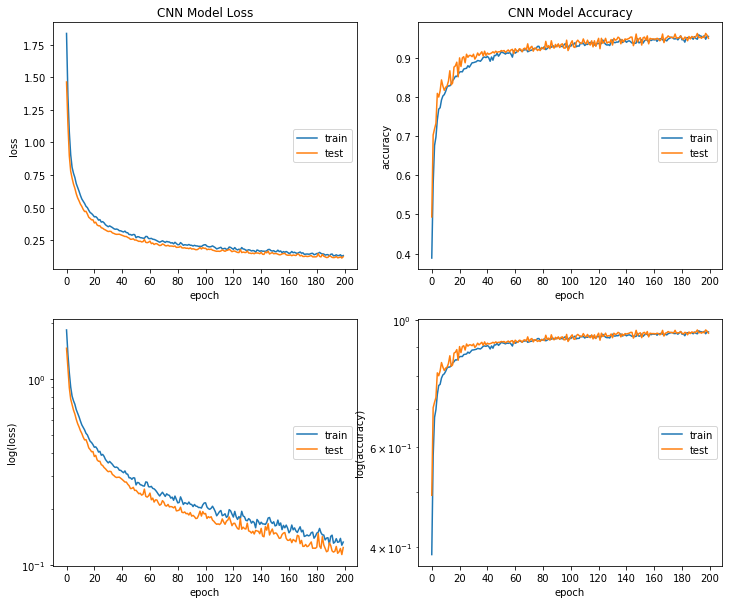

In [558]:
plot_loss_history(CNNmodel)

In [559]:
cnn = CNN_Model(cube_std_3d.shape[2], filtersize)
cnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel = cnn.fit({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels, 
                     validation_data=({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels),
                     epochs=60, batch_size=512)

Epoch 1/60
5/5 [==============================] - 1s 104ms/step - loss: 1.8376 - accuracy: 0.3293 - val_loss: 1.4525 - val_accuracy: 0.4953
Epoch 2/60
5/5 [==============================] - 0s 43ms/step - loss: 1.3711 - accuracy: 0.6051 - val_loss: 1.1275 - val_accuracy: 0.6625
Epoch 3/60
5/5 [==============================] - 0s 51ms/step - loss: 1.0968 - accuracy: 0.6625 - val_loss: 0.8920 - val_accuracy: 0.7500
Epoch 4/60
5/5 [==============================] - 0s 40ms/step - loss: 0.9035 - accuracy: 0.7266 - val_loss: 0.7655 - val_accuracy: 0.7656
Epoch 5/60
5/5 [==============================] - 0s 39ms/step - loss: 0.7958 - accuracy: 0.7535 - val_loss: 0.6983 - val_accuracy: 0.8109
Epoch 6/60
5/5 [==============================] - 0s 33ms/step - loss: 0.7444 - accuracy: 0.7746 - val_loss: 0.6440 - val_accuracy: 0.8031
Epoch 7/60
5/5 [==============================] - 0s 35ms/step - loss: 0.6991 - accuracy: 0.7953 - val_loss: 0.5955 - val_accuracy: 0.8250
Epoch 8/60
5/5 [==========

In [560]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn.evaluate({"spectra":cube_train2, "spatial":xy_train}, cube_train_labels)
test_loss, test_acc = cnn.evaluate({"spectra":cube_test2, "spatial":xy_test}, cube_test_labels)

print(train_acc, test_acc)

20/20 [==============================] - 0s 4ms/step - loss: 0.2129 - accuracy: 0.9203
0.932421863079071 0.9203125238418579


### Predict pixel classification on veg_00108

In [561]:
cube_standard_1 = cube_standard.reshape(cube_standard.shape[0], cube_standard.shape[1], 1)
print(cube_standard_1.shape)
xy_2d = xy.reshape((xy.shape[0] * xy.shape[1]), xy.shape[2])
print(xy_2d.shape)

(2560000, 106, 1)
(2560000, 2)


In [562]:
# classify entire binned cube
import time
start_time = time.time()

probCube = cnn.predict({"spectra":cube_standard_1, "spatial":xy_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:04:29


In [563]:
predictCube = probCube.argmax(axis=-1)

In [564]:
predictCube_reshape = predictCube.reshape(cube_sub.shape[1], cube_sub.shape[2])

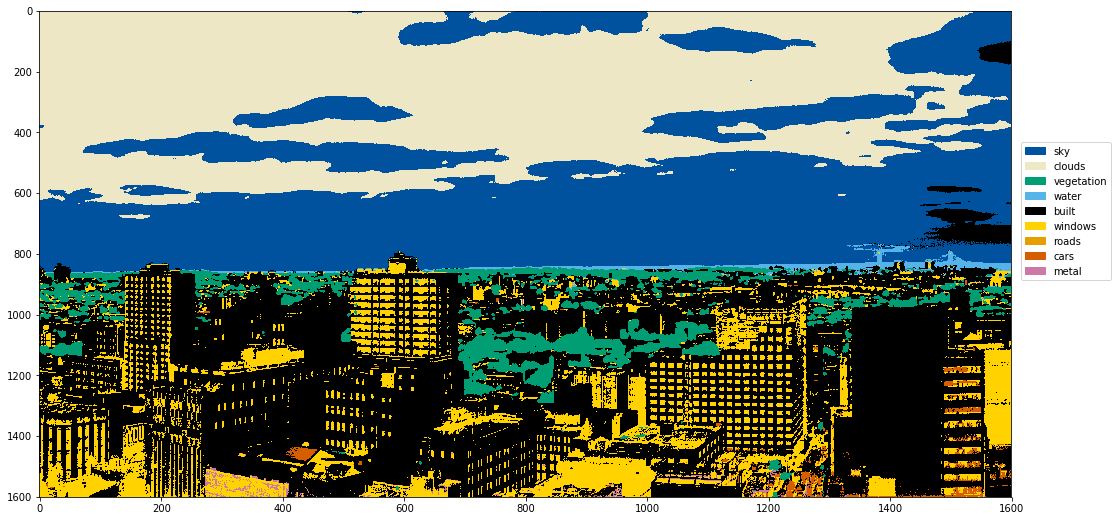

In [565]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_1_108_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

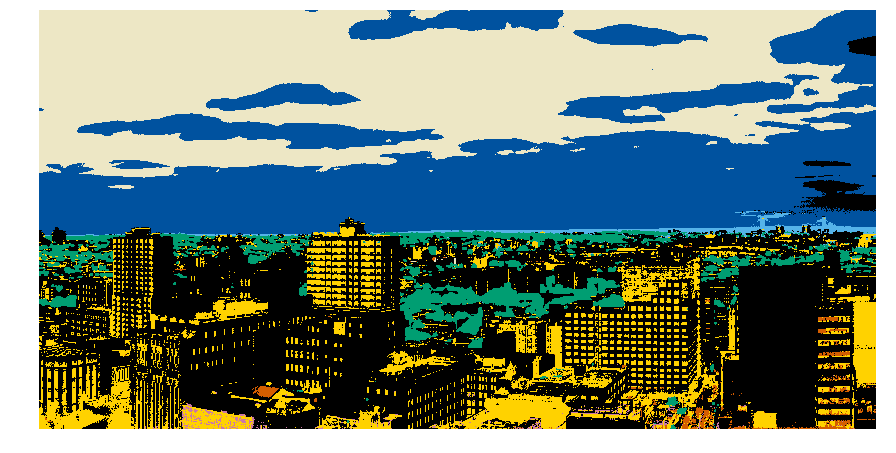

In [566]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_108_binned_{0}_test_108_predict_map.png".format(num_of_bins), 
            bbox_inches='tight')

In [567]:
import pickle
pickle.dump(predictCube_reshape,
            open("./plots/CNN_Model2_spatial_train_108_binned_{0}_test_108_predict_map.pickle".format(num_of_bins), 
                 "wb"))

### Evaluation Metrics (veg_00108)

In [568]:
labels_pred_sky = predictCube_reshape[sky_coords[sky_test_ind[:], 0], sky_coords[sky_test_ind[:], 1]]
labels_pred_clouds = predictCube_reshape[clouds_coords[clouds_test_ind[:], 0], clouds_coords[clouds_test_ind[:],1]]
labels_pred_veg = predictCube_reshape[veg_coords[veg_test_ind[:],0], veg_coords[veg_test_ind[:],1]]
labels_pred_wtr = predictCube_reshape[wtr_coords[wtr_test_ind[:],0], wtr_coords[wtr_test_ind[:],1]]
labels_pred_blt = predictCube_reshape[blt_coords[blt_test_ind[:],0], blt_coords[blt_test_ind[:],1]]
labels_pred_windows = predictCube_reshape[windows_coords[windows_test_ind[:],0], windows_coords[windows_test_ind[:],1]]
labels_pred_rds = predictCube_reshape[rds_coords[rds_test_ind[:],0], rds_coords[rds_test_ind[:],1]]
labels_pred_cars = predictCube_reshape[cars_coords[cars_test_ind[:],0], cars_coords[cars_test_ind[:],1]]
labels_pred_mtl = predictCube_reshape[mtl_coords[mtl_test_ind[:],0], mtl_coords[mtl_test_ind[:],1]]

labels_pred = np.concatenate((labels_pred_sky, labels_pred_clouds, labels_pred_veg, labels_pred_wtr, 
                             labels_pred_blt, labels_pred_windows, labels_pred_rds, labels_pred_cars, labels_pred_mtl))

In [569]:
labels_true_sky = np.full(len(sky_test_ind), 0)
labels_true_clouds = np.full(len(clouds_test_ind), 1)
labels_true_veg = np.full(len(veg_test_ind), 2)
labels_true_wtr = np.full(len(wtr_test_ind), 3)
labels_true_blt = np.full(len(blt_test_ind), 4)
labels_true_windows = np.full(len(windows_test_ind), 5)
labels_true_rds = np.full(len(rds_test_ind), 6)
labels_true_cars = np.full(len(cars_test_ind), 7)
labels_true_mtl = np.full(len(mtl_test_ind), 8)

labels_true = np.concatenate((labels_true_sky, labels_true_clouds, labels_true_veg, labels_true_wtr, 
                             labels_true_blt, labels_true_windows, labels_true_rds, labels_true_cars, labels_true_mtl))

In [570]:
print(labels_pred.shape)
print(labels_true.shape)

(640,)
(640,)


In [571]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels_true, labels_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels_true, labels_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels_true, labels_pred, target_names=target_names))

Confusion Matrix
[[ 59   1   0   0   0   0   0   0   0]
 [  0 100   0   0   0   0   0   0   0]
 [  0   0 118   0   2   0   0   0   0]
 [  0   0   0  10   0   0   0   0   0]
 [  0   0   0   0 198   5   0   1   0]
 [  0   0   0   0   4  94   0   2   0]
 [  0   0   0   0   6   0   0   0   0]
 [  0   0   0   0   4   7   0   9   0]
 [  0   0   0   0  15   4   0   0   1]]

Accuracy Score
0.9203125

Classification Report
             precision    recall  f1-score   support

        sky       1.00      0.98      0.99        60
     clouds       0.99      1.00      1.00       100
 vegetation       1.00      0.98      0.99       120
      water       1.00      1.00      1.00        10
      built       0.86      0.97      0.91       204
    windows       0.85      0.94      0.90       100
      roads       0.00      0.00      0.00         6
       cars       0.75      0.45      0.56        20
      metal       1.00      0.05      0.10        20

avg / total       0.92      0.92      0.90       6

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [572]:
f = open("./metrics/CNN_Model2_spatial_train_108_binned_{0}_test_108_metrics.txt".format(num_of_bins), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels_true, labels_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels_true, labels_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels_true, labels_pred, target_names=target_names))
f.close()

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


---
## CNN trained on veg_00000 (Scene 1-b South Facing @ ~6pm)

In [44]:
fname0 = "../../image_files/veg_00000.raw"
cube0 = read_hyper(fname0)

reading and parsing ../../image_files/veg_00000.hdr...
reading ../../image_files/veg_00000.raw...


In [45]:
cube_sub0 = cube0.data[:, :, :].astype(float)
print(cube_sub0.shape)

(848, 1600, 1600)


In [46]:
cube_reshaped0 = cube_sub0.transpose(1, 2, 0).reshape((cube_sub0.shape[1] * cube_sub0.shape[2]), cube_sub0.shape[0])
print(cube_reshaped0.shape)

(2560000, 848)


In [573]:
cube_standard0 = (cube_reshaped0 - cube_reshaped0.mean(1, keepdims=True)) / cube_reshaped0.std(1, keepdims=True)
print(cube_standard0.shape)

(2560000, 848)


#### Reading manually classified set for training and testing

In [324]:
sky_coords0 = read_labelled_coordinates("1_sky", "000")
clouds_coords0 = read_labelled_coordinates("2_clouds", "000")
veg_coords0 = read_labelled_coordinates("3_vegetation", "000")
wtr_coords0 = read_labelled_coordinates("4_water", "000")
blt_coords0 = read_labelled_coordinates("5_buildings", "000")
windows_coords0 = read_labelled_coordinates("6_windows", "000")
rds_coords0 = read_labelled_coordinates("7_roads", "000")
cars_coords0 = read_labelled_coordinates("8_cars", "000")
mtl_coords0 = read_labelled_coordinates("9_metal", "000")

1_sky: (400, 2)
2_clouds: (500, 2)
3_vegetation: (610, 2)
4_water: (0,)
5_buildings: (1200, 2)
6_windows: (500, 2)
7_roads: (60, 2)
8_cars: (55, 2)
9_metal: (230, 2)


In [49]:
# create position array and normalize

xy0 = coords(cube_sub0.shape[1], cube_sub0.shape[2])
xy0 = xy0/xy0.max()

### Bin Spectra

In [574]:
cube_binned0 = np.zeros(shape=(cube_standard0.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binned0[:, i] = cube_standard0[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binned0.shape)

(2560000, 106)


In [575]:
cube_standard0 = cube_binned0
print(cube_standard0.shape)

(2560000, 106)


#### split classified pixels into 80% training and 20% testing sets

In [576]:
trrat = 0.8
sky_train_ind0, sky_test_ind0 = split_train_test_indices(sky_coords0, 10, trrat, "sky")
clouds_train_ind0, clouds_test_ind0 = split_train_test_indices(clouds_coords0, 20, trrat, "clouds")
veg_train_ind0, veg_test_ind0 = split_train_test_indices(veg_coords0, 30, trrat, "veg")
#wtr_train_ind0, wtr_test_ind0 = split_train_test_indices(wtr_coords0, 40, trrat, "wtr")
blt_train_ind0, blt_test_ind0 = split_train_test_indices(blt_coords0, 50, trrat, "blt")
windows_train_ind0, windows_test_ind0 = split_train_test_indices(windows_coords0, 60, trrat, "windows")
rds_train_ind0, rds_test_ind0 = split_train_test_indices(rds_coords0, 70, trrat, "rds")
cars_train_ind0, cars_test_ind0 = split_train_test_indices(cars_coords0, 80, trrat, "cars")
mtl_train_ind0, mtl_test_ind0 = split_train_test_indices(mtl_coords0, 90, trrat, "mtl")

sky: 320 80
clouds: 400 100
veg: 488 122
blt: 960 240
windows: 400 100
rds: 48 12
cars: 44 11
mtl: 184 46


In [577]:
cube_std0_3d = cube_standard0.reshape(cube_sub0.shape[1], cube_sub0.shape[2], num_of_bins)
print(cube_std0_3d.shape)
print(xy0.shape)

(1600, 1600, 106)
(1600, 1600, 2)


In [578]:
cube_sky_train0 = cube_std0_3d[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
cube_sky_test0 = cube_std0_3d[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
sky_xy_train0 = xy0[sky_coords0[sky_train_ind0[:], 0], sky_coords0[sky_train_ind0[:], 1], :]
sky_xy_test0 = xy0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1], :]
print("sky ", cube_sky_train0.shape, cube_sky_test0.shape)


cube_clouds_train0 = cube_std0_3d[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
cube_clouds_test0 = cube_std0_3d[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
clouds_xy_train0 = xy0[clouds_coords0[clouds_train_ind0[:], 0], clouds_coords0[clouds_train_ind0[:], 1], :]
clouds_xy_test0 = xy0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:], 1], :]
print("clouds ", cube_clouds_train0.shape, cube_clouds_test0.shape)

cube_veg_train0 = cube_std0_3d[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
cube_veg_test0 = cube_std0_3d[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
veg_xy_train0 = xy0[veg_coords0[veg_train_ind0[:], 0], veg_coords0[veg_train_ind0[:], 1], :]
veg_xy_test0 = xy0[veg_coords0[veg_test_ind0[:], 0], veg_coords0[veg_test_ind0[:], 1], :]
print("vegetation ", cube_veg_train0.shape, cube_veg_test0.shape)

#cube_wtr_train0 = cube_std0_3d[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#cube_wtr_test0 = cube_std0_3d[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#wtr_xy_train0 = xy0[wtr_coords0[wtr_train_ind0[:], 0], wtr_coords0[wtr_train_ind0[:], 1], :]
#wtr_xy_test0 = xy0[wtr_coords0[wtr_test_ind0[:], 0], wtr_coords0[wtr_test_ind0[:], 1], :]
#print("water ", cube_wtr_train0.shape, cube_wtr_test0.shape)

cube_blt_train0 = cube_std0_3d[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
cube_blt_test0 = cube_std0_3d[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
blt_xy_train0 = xy0[blt_coords0[blt_train_ind0[:], 0], blt_coords0[blt_train_ind0[:], 1], :]
blt_xy_test0 = xy0[blt_coords0[blt_test_ind0[:], 0], blt_coords0[blt_test_ind0[:], 1], :]
print("built ", cube_blt_train0.shape, cube_blt_test0.shape)

cube_windows_train0 = cube_std0_3d[windows_coords0[windows_train_ind0[:],0], windows_coords0[windows_train_ind0[:],1],:]
cube_windows_test0 = cube_std0_3d[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
windows_xy_train0 = xy0[windows_coords0[windows_train_ind0[:], 0], windows_coords0[windows_train_ind0[:], 1], :]
windows_xy_test0 = xy0[windows_coords0[windows_test_ind0[:], 0], windows_coords0[windows_test_ind0[:], 1], :]
print("windows ", cube_windows_train0.shape, cube_windows_test0.shape)

cube_rds_train0 = cube_std0_3d[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
cube_rds_test0 = cube_std0_3d[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
rds_xy_train0 = xy0[rds_coords0[rds_train_ind0[:], 0], rds_coords0[rds_train_ind0[:], 1], :]
rds_xy_test0 = xy0[rds_coords0[rds_test_ind0[:], 0], rds_coords0[rds_test_ind0[:], 1], :]
print("roads ", cube_rds_train0.shape, cube_rds_test0.shape)

cube_cars_train0 = cube_std0_3d[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cube_cars_test0 = cube_std0_3d[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
cars_xy_train0 = xy0[cars_coords0[cars_train_ind0[:], 0], cars_coords0[cars_train_ind0[:], 1], :]
cars_xy_test0 = xy0[cars_coords0[cars_test_ind0[:], 0], cars_coords0[cars_test_ind0[:], 1], :]
print("cars ", cube_cars_train0.shape, cube_cars_test0.shape)

cube_mtl_train0 = cube_std0_3d[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
cube_mtl_test0 = cube_std0_3d[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
mtl_xy_train0 = xy0[mtl_coords0[mtl_train_ind0[:], 0], mtl_coords0[mtl_train_ind0[:], 1], :]
mtl_xy_test0 = xy0[mtl_coords0[mtl_test_ind0[:], 0], mtl_coords0[mtl_test_ind0[:], 1], :]
print("metal ", cube_mtl_train0.shape, cube_mtl_test0.shape)

sky  (320, 106) (80, 106)
clouds  (400, 106) (100, 106)
vegetation  (488, 106) (122, 106)
built  (960, 106) (240, 106)
windows  (400, 106) (100, 106)
roads  (48, 106) (12, 106)
cars  (44, 106) (11, 106)
metal  (184, 106) (46, 106)


In [579]:
cube_train0 = np.concatenate((cube_sky_train0, cube_clouds_train0, cube_veg_train0, cube_blt_train0,
                             cube_windows_train0, cube_rds_train0, cube_cars_train0, cube_mtl_train0), axis=0)
cube_train_labels0 = [0]*cube_sky_train0.shape[0] + [1]*cube_clouds_train0.shape[0] \
                + [2]*cube_veg_train0.shape[0] + [4]*cube_blt_train0.shape[0] \
                + [5]*cube_windows_train0.shape[0] + [6]*cube_rds_train0.shape[0] \
                + [7]*cube_cars_train0.shape[0] + [8]*cube_mtl_train0.shape[0]
xy_train0 = np.concatenate((sky_xy_train0, clouds_xy_train0, veg_xy_train0, blt_xy_train0,
                             windows_xy_train0, rds_xy_train0, cars_xy_train0, mtl_xy_train0), axis=0)

cube_test0 = np.concatenate((cube_sky_test0, cube_clouds_test0, cube_veg_test0, cube_blt_test0,
                             cube_windows_test0, cube_rds_test0, cube_cars_test0, cube_mtl_test0), axis=0)
cube_test_labels0 = [0]*cube_sky_test0.shape[0] + [1]*cube_clouds_test0.shape[0] \
                + [2]*cube_veg_test0.shape[0] + [4]*cube_blt_test0.shape[0] \
                + [5]*cube_windows_test0.shape[0] + [6]*cube_rds_test0.shape[0] \
                + [7]*cube_cars_test0.shape[0] + [8]*cube_mtl_test0.shape[0]
xy_test0 = np.concatenate((sky_xy_test0, clouds_xy_test0, veg_xy_test0, blt_xy_test0,
                             windows_xy_test0, rds_xy_test0, cars_xy_test0, mtl_xy_test0), axis=0)

In [580]:
cube_train_labels0 = np.array(cube_train_labels0)
cube_test_labels0 = np.array(cube_test_labels0)

print(cube_train0.shape, cube_train_labels0.shape, xy_train0.shape)
print(cube_test0.shape, cube_test_labels0.shape, xy_test0.shape)

(2844, 106) (2844,) (2844, 2)
(711, 106) (711,) (711, 2)


### Train CNN

In [581]:
cnn0 = CNN_Model(cube_std0_3d.shape[2], filtersize)
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [582]:
#keras.utils.plot_model(cnn0, show_shapes=True)
#cnn0.summary()

cube_train02 = cube_train0.reshape(cube_train0.shape[0], cube_train0.shape[1], 1)
cube_test02 = cube_test0.reshape(cube_test0.shape[0], cube_test0.shape[1], 1)

In [583]:
CNNmodel0 = cnn0.fit({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0),
                     epochs=200, batch_size=512)

Epoch 1/200
6/6 [==============================] - 1s 152ms/step - loss: 1.8870 - accuracy: 0.2971 - val_loss: 1.4827 - val_accuracy: 0.4515
Epoch 2/200
6/6 [==============================] - 0s 72ms/step - loss: 1.3767 - accuracy: 0.5953 - val_loss: 1.1719 - val_accuracy: 0.6329
Epoch 3/200
6/6 [==============================] - 0s 52ms/step - loss: 1.1040 - accuracy: 0.6392 - val_loss: 1.0000 - val_accuracy: 0.6737
Epoch 4/200
6/6 [==============================] - 0s 68ms/step - loss: 0.9513 - accuracy: 0.6674 - val_loss: 0.8680 - val_accuracy: 0.6962
Epoch 5/200
6/6 [==============================] - 0s 47ms/step - loss: 0.8333 - accuracy: 0.6888 - val_loss: 0.7620 - val_accuracy: 0.6948
Epoch 6/200
6/6 [==============================] - 0s 33ms/step - loss: 0.7611 - accuracy: 0.7046 - val_loss: 0.7092 - val_accuracy: 0.6990
Epoch 7/200
6/6 [==============================] - 0s 34ms/step - loss: 0.7098 - accuracy: 0.7233 - val_loss: 0.7075 - val_accuracy: 0.6892
Epoch 8/200
6/6 [==

6/6 [==============================] - 0s 34ms/step - loss: 0.2572 - accuracy: 0.9051 - val_loss: 0.3079 - val_accuracy: 0.8973
Epoch 118/200
6/6 [==============================] - 0s 40ms/step - loss: 0.2610 - accuracy: 0.9058 - val_loss: 0.3128 - val_accuracy: 0.8889
Epoch 119/200
6/6 [==============================] - 0s 34ms/step - loss: 0.2636 - accuracy: 0.9044 - val_loss: 0.3109 - val_accuracy: 0.8819
Epoch 120/200
6/6 [==============================] - 0s 37ms/step - loss: 0.2647 - accuracy: 0.9058 - val_loss: 0.3129 - val_accuracy: 0.8889
Epoch 121/200
6/6 [==============================] - 0s 40ms/step - loss: 0.2460 - accuracy: 0.9037 - val_loss: 0.3017 - val_accuracy: 0.8987
Epoch 122/200
6/6 [==============================] - 0s 36ms/step - loss: 0.2588 - accuracy: 0.9121 - val_loss: 0.3129 - val_accuracy: 0.8903
Epoch 123/200
6/6 [==============================] - 0s 36ms/step - loss: 0.2620 - accuracy: 0.9023 - val_loss: 0.3221 - val_accuracy: 0.8790
Epoch 124/200
6/6 [=

Epoch 175/200
6/6 [==============================] - 0s 45ms/step - loss: 0.2108 - accuracy: 0.9195 - val_loss: 0.2646 - val_accuracy: 0.9114
Epoch 176/200
6/6 [==============================] - 0s 39ms/step - loss: 0.2056 - accuracy: 0.9258 - val_loss: 0.2655 - val_accuracy: 0.9086
Epoch 177/200
6/6 [==============================] - 0s 38ms/step - loss: 0.2053 - accuracy: 0.9272 - val_loss: 0.2689 - val_accuracy: 0.9072
Epoch 178/200
6/6 [==============================] - 0s 41ms/step - loss: 0.2049 - accuracy: 0.9230 - val_loss: 0.2737 - val_accuracy: 0.9058
Epoch 179/200
6/6 [==============================] - 0s 45ms/step - loss: 0.2016 - accuracy: 0.9276 - val_loss: 0.2654 - val_accuracy: 0.9100
Epoch 180/200
6/6 [==============================] - 0s 37ms/step - loss: 0.2047 - accuracy: 0.9212 - val_loss: 0.2637 - val_accuracy: 0.9044
Epoch 181/200
6/6 [==============================] - 0s 40ms/step - loss: 0.2066 - accuracy: 0.9290 - val_loss: 0.2781 - val_accuracy: 0.8973
Epoch 

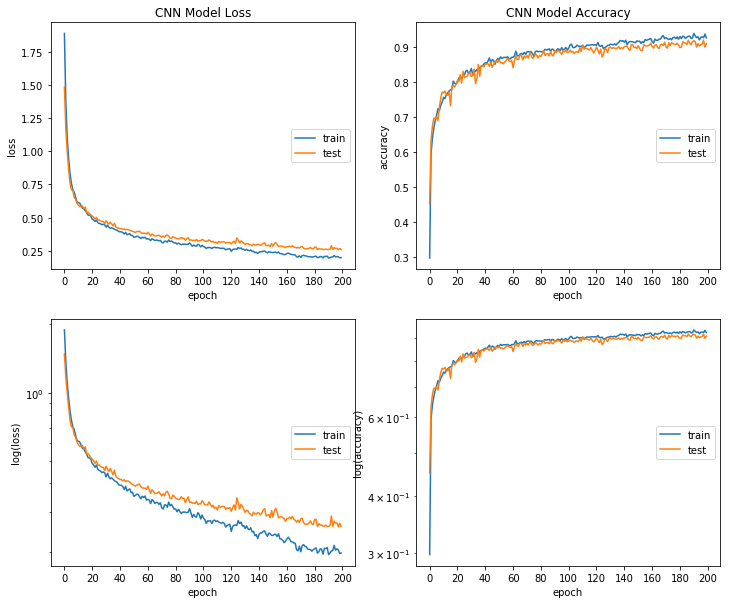

In [584]:
plot_loss_history(CNNmodel0)

In [585]:
cnn0 = CNN_Model(cube_std0_3d.shape[2], filtersize)
cnn0.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodel0 = cnn0.fit({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0, 
                     validation_data=({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0),
                     epochs=50, batch_size=512)

Epoch 1/50
6/6 [==============================] - 1s 84ms/step - loss: 1.8072 - accuracy: 0.3161 - val_loss: 1.4108 - val_accuracy: 0.6020
Epoch 2/50
6/6 [==============================] - 0s 47ms/step - loss: 1.3185 - accuracy: 0.5904 - val_loss: 1.1395 - val_accuracy: 0.6273
Epoch 3/50
6/6 [==============================] - 0s 40ms/step - loss: 1.0737 - accuracy: 0.6406 - val_loss: 0.9501 - val_accuracy: 0.6428
Epoch 4/50
6/6 [==============================] - 0s 37ms/step - loss: 0.9113 - accuracy: 0.6811 - val_loss: 0.8445 - val_accuracy: 0.6976
Epoch 5/50
6/6 [==============================] - 0s 32ms/step - loss: 0.8242 - accuracy: 0.6941 - val_loss: 0.7359 - val_accuracy: 0.7300
Epoch 6/50
6/6 [==============================] - 0s 38ms/step - loss: 0.7378 - accuracy: 0.7194 - val_loss: 0.6875 - val_accuracy: 0.7384
Epoch 7/50
6/6 [==============================] - 0s 32ms/step - loss: 0.6797 - accuracy: 0.7363 - val_loss: 0.6526 - val_accuracy: 0.7651
Epoch 8/50
6/6 [===========

In [586]:
# model accuracy on training and testing sets

train_loss, train_acc = cnn0.evaluate({"spectra":cube_train02, "spatial":xy_train0}, cube_train_labels0)
test_loss, test_acc = cnn0.evaluate({"spectra":cube_test02, "spatial":xy_test0}, cube_test_labels0)

print(train_acc, test_acc)

23/23 [==============================] - 0s 5ms/step - loss: 0.3927 - accuracy: 0.8579
0.8906469941139221 0.8579465746879578


### Predict pixel classification on veg_00000

In [587]:
cube_standard0_1 = cube_standard0.reshape(cube_standard0.shape[0], cube_standard0.shape[1], 1)
print(cube_standard0_1.shape)
xy0_2d = xy0.reshape((xy0.shape[0] * xy0.shape[1]), xy0.shape[2])
print(xy0_2d.shape)

(2560000, 106, 1)
(2560000, 2)


In [588]:
# classify entire binned cube
import time
start_time = time.time()

probCube0 = cnn0.predict({"spectra":cube_standard0_1, "spatial":xy0_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:04:27


In [ ]:
predictCube0 = probCube0.argmax(axis=-1)

In [ ]:
predictCube_reshape0 = predictCube0.reshape(cube_sub0.shape[1], cube_sub0.shape[2])

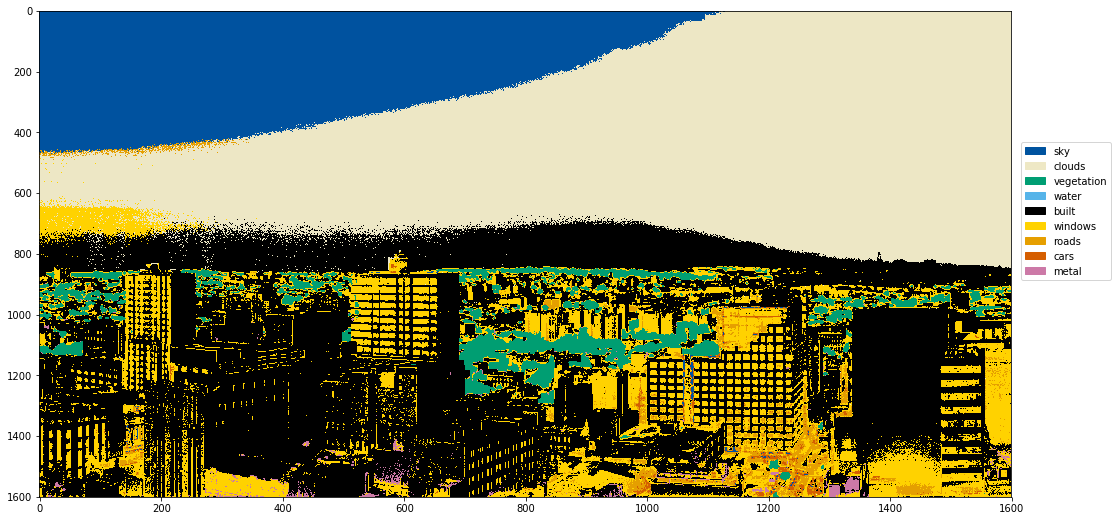

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.5)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_3_000_predict_map.png", 
#bbox_extra_artists=(lgd,), bbox_inches='tight')

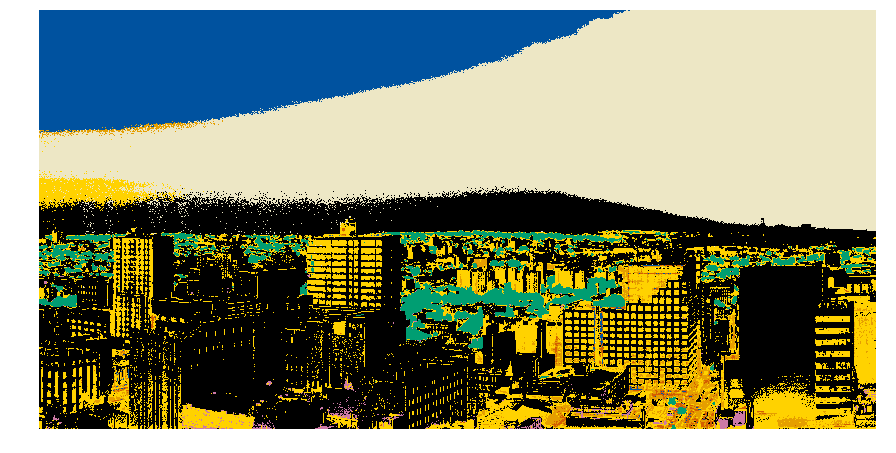

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshape0])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.5)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_000_binned_{0}_test_000_predict_map.png".format(num_of_bins),
            bbox_inches='tight', dpi=300)

In [ ]:
import pickle
pickle.dump(predictCube_reshape0, 
            open("./plots/CNN_Model2_spatial_train_000_binned_{0}_test_000_predict_map.pickle".format(num_of_bins), "wb"))

In [ ]:
wtr_coords0=np.array([[0,0]])

### Evaluation Metrics (veg_00000)

In [ ]:
labels0_pred_sky = predictCube_reshape0[sky_coords0[sky_test_ind0[:], 0], sky_coords0[sky_test_ind0[:], 1]]
labels0_pred_clouds = predictCube_reshape0[clouds_coords0[clouds_test_ind0[:], 0], clouds_coords0[clouds_test_ind0[:],1]]
labels0_pred_veg = predictCube_reshape0[veg_coords0[veg_test_ind0[:],0], veg_coords0[veg_test_ind0[:],1]]
#labels0_pred_wtr = predictCube_reshape0[wtr_coords0[wtr_test_ind0[:],0], wtr_coords0[wtr_test_ind0[:],1]]
labels0_pred_blt = predictCube_reshape0[blt_coords0[blt_test_ind0[:],0], blt_coords0[blt_test_ind0[:],1]]
labels0_pred_windows = predictCube_reshape0[windows_coords0[windows_test_ind0[:],0], windows_coords0[windows_test_ind0[:],1]]
labels0_pred_rds = predictCube_reshape0[rds_coords0[rds_test_ind0[:],0], rds_coords0[rds_test_ind0[:],1]]
labels0_pred_cars = predictCube_reshape0[cars_coords0[cars_test_ind0[:],0], cars_coords0[cars_test_ind0[:],1]]
labels0_pred_mtl = predictCube_reshape0[mtl_coords0[mtl_test_ind0[:],0], mtl_coords0[mtl_test_ind0[:],1]]

labels0_pred = np.concatenate((labels0_pred_sky, labels0_pred_clouds, labels0_pred_veg, #labels0_pred_wtr, 
                             labels0_pred_blt, labels0_pred_windows, labels0_pred_rds, 
                               labels0_pred_cars, labels0_pred_mtl))

In [ ]:
labels0_true_sky = np.full(len(sky_test_ind0), 0)
labels0_true_clouds = np.full(len(clouds_test_ind0), 1)
labels0_true_veg = np.full(len(veg_test_ind0), 2)
#labels0_true_wtr = np.full(len(wtr_test_ind0), 3)
labels0_true_blt = np.full(len(blt_test_ind0), 4)
labels0_true_windows = np.full(len(windows_test_ind0), 5)
labels0_true_rds = np.full(len(rds_test_ind0), 6)
labels0_true_cars = np.full(len(cars_test_ind0), 7)
labels0_true_mtl = np.full(len(mtl_test_ind0), 8)

labels0_true = np.concatenate((labels0_true_sky, labels0_true_clouds, labels0_true_veg, #labels0_true_wtr, 
                             labels0_true_blt, labels0_true_windows, labels0_true_rds, labels0_true_cars, labels0_true_mtl))

In [ ]:
print(labels0_pred.shape)
print(labels0_true.shape)

In [600]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labels0_true, labels0_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labels0_true, labels0_pred))

target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))

Confusion Matrix
[[ 80   0   0   0   0   0   0   0]
 [  0  99   0   1   0   0   0   0]
 [  0   0 119   2   1   0   0   0]
 [  0   0   0 231   9   0   0   0]
 [  0   0   0  42  57   0   0   1]
 [  0   0   0   0   1  11   0   0]
 [  2   0   0   0   0   4   5   0]
 [  0   0   0  34   4   0   0   8]]

Accuracy Score
0.8579465541490858

Classification Report
             precision    recall  f1-score   support

        sky       0.98      1.00      0.99        80
     clouds       1.00      0.99      0.99       100
 vegetation       1.00      0.98      0.99       122
      built       0.75      0.96      0.84       240
    windows       0.79      0.57      0.66       100
      roads       0.73      0.92      0.81        12
       cars       1.00      0.45      0.62        11
      metal       0.89      0.17      0.29        46

avg / total       0.87      0.86      0.84       711



In [ ]:
f = open("./metrics/CNN_Model2_spatial_train_000_binned_{0}_test_000_metrics.txt".format(num_of_bins), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labels0_true, labels0_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labels0_true, labels0_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labels0_true, labels0_pred, target_names=target_names))
f.close()

---
## CNN trained on North Facing Image

In [76]:
fname_north = "../../image_files/scan1_slow_roof_VNIR.raw"
cube_north = read_hyper(fname_north)

reading and parsing ../../image_files/scan1_slow_roof_VNIR.hdr...
reading ../../image_files/scan1_slow_roof_VNIR.raw...


In [77]:
cube_sub_north = cube_north.data[:, :, :].astype(float)
print(cube_sub_north.shape)

(872, 1600, 1247)


In [78]:
cube_reshaped_north = cube_sub_north.transpose(1, 2, 0).reshape((cube_sub_north.shape[1] * cube_sub_north.shape[2]), cube_sub_north.shape[0])
print(cube_reshaped_north.shape)

(1995200, 872)


In [601]:
cube_standard_north = (cube_reshaped_north - cube_reshaped_north.mean(1, keepdims=True)) / cube_reshaped_north.std(1, keepdims=True)
print(cube_standard_north.shape)

(1995200, 872)


#### Reading manually classified set for training and testing

In [602]:
sky_coordsn = read_labelled_coordinates("1_sky", "north")
clouds_coordsn = read_labelled_coordinates("2_clouds", "north")
veg_coordsn = read_labelled_coordinates("3_vegetation", "north")
wtr_coordsn = read_labelled_coordinates("4_water", "north")
blt_coordsn = read_labelled_coordinates("5_buildings", "north")
windows_coordsn = read_labelled_coordinates("6_windows", "north")
rds_coordsn = read_labelled_coordinates("7_roads", "north")
cars_coordsn = read_labelled_coordinates("8_cars", "north")
mtl_coordsn = read_labelled_coordinates("9_metal", "north")

1_sky: (300, 2)
2_clouds: (200, 2)
3_vegetation: (700, 2)
4_water: (620, 2)
5_buildings: (1600, 2)
6_windows: (600, 2)
7_roads: (250, 2)
8_cars: (250, 2)
9_metal: (185, 2)


In [603]:
xyn = coords(cube_sub_north.shape[1], cube_sub_north.shape[2])
xyn = xyn/xyn.max()

### Bin Spectra

In [604]:
bin_ind = []

for i in range(0, num_of_bins):
    low_ind = int(i*int(cube_sub_north.shape[0]/num_of_bins))
    upp_ind = int(low_ind + int(cube_sub_north.shape[0]/num_of_bins))
    bin_ind.append([low_ind, upp_ind])
bin_ind[-1][-1] = cube_sub_north.shape[0]

print(len(bin_ind))
print(bin_ind)

106
[[0, 8], [8, 16], [16, 24], [24, 32], [32, 40], [40, 48], [48, 56], [56, 64], [64, 72], [72, 80], [80, 88], [88, 96], [96, 104], [104, 112], [112, 120], [120, 128], [128, 136], [136, 144], [144, 152], [152, 160], [160, 168], [168, 176], [176, 184], [184, 192], [192, 200], [200, 208], [208, 216], [216, 224], [224, 232], [232, 240], [240, 248], [248, 256], [256, 264], [264, 272], [272, 280], [280, 288], [288, 296], [296, 304], [304, 312], [312, 320], [320, 328], [328, 336], [336, 344], [344, 352], [352, 360], [360, 368], [368, 376], [376, 384], [384, 392], [392, 400], [400, 408], [408, 416], [416, 424], [424, 432], [432, 440], [440, 448], [448, 456], [456, 464], [464, 472], [472, 480], [480, 488], [488, 496], [496, 504], [504, 512], [512, 520], [520, 528], [528, 536], [536, 544], [544, 552], [552, 560], [560, 568], [568, 576], [576, 584], [584, 592], [592, 600], [600, 608], [608, 616], [616, 624], [624, 632], [632, 640], [640, 648], [648, 656], [656, 664], [664, 672], [672, 680], [68

In [605]:
cube_binnedn = np.zeros(shape=(cube_standard_north.shape[0], num_of_bins))

for i in range(num_of_bins):
    cube_binnedn[:, i] = cube_standard_north[:, bin_ind[i][0]:bin_ind[i][1]].mean(1)

print(cube_binnedn.shape)

(1995200, 106)


In [606]:
cube_standard_north = cube_binnedn
print(cube_standard_north.shape)

(1995200, 106)


#### split classified pixels into 80% training and 20% testing sets

In [607]:
trrat = 0.8
sky_train_indn, sky_test_indn = split_train_test_indices(sky_coordsn, 100, trrat, "sky")
clouds_train_indn, clouds_test_indn = split_train_test_indices(clouds_coordsn, 200, trrat, "clouds")
veg_train_indn, veg_test_indn = split_train_test_indices(veg_coordsn, 300, trrat, "veg")
wtr_train_indn, wtr_test_indn = split_train_test_indices(wtr_coordsn, 400, trrat, "wtr")
blt_train_indn, blt_test_indn = split_train_test_indices(blt_coordsn, 500, trrat, "blt")
windows_train_indn, windows_test_indn = split_train_test_indices(windows_coordsn, 600, trrat, "windows")
rds_train_indn, rds_test_indn = split_train_test_indices(rds_coordsn, 700, trrat, "rds")
cars_train_indn, cars_test_indn = split_train_test_indices(cars_coordsn, 800, trrat, "cars")
mtl_train_indn, mtl_test_indn = split_train_test_indices(mtl_coordsn, 900, trrat, "mtl")

sky: 240 60
clouds: 160 40
veg: 560 140
wtr: 496 124
blt: 1280 320
windows: 480 120
rds: 200 50
cars: 200 50
mtl: 148 37


In [608]:
cube_stdn_3d = cube_standard_north.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2], num_of_bins)
print(cube_stdn_3d.shape)
print(xyn.shape)

(1600, 1247, 106)
(1600, 1247, 2)


In [609]:
cube_sky_trainn = cube_stdn_3d[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
cube_sky_testn = cube_stdn_3d[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
sky_xy_trainn = xyn[sky_coordsn[sky_train_indn[:], 0], sky_coordsn[sky_train_indn[:], 1], :]
sky_xy_testn = xyn[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1], :]
print("sky ", cube_sky_trainn.shape, cube_sky_testn.shape)

cube_clouds_trainn = cube_stdn_3d[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
cube_clouds_testn = cube_stdn_3d[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
clouds_xy_trainn = xyn[clouds_coordsn[clouds_train_indn[:], 0], clouds_coordsn[clouds_train_indn[:], 1], :]
clouds_xy_testn = xyn[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:], 1], :]
print("clouds ", cube_clouds_trainn.shape, cube_clouds_testn.shape)

cube_veg_trainn = cube_stdn_3d[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
cube_veg_testn = cube_stdn_3d[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
veg_xy_trainn = xyn[veg_coordsn[veg_train_indn[:], 0], veg_coordsn[veg_train_indn[:], 1], :]
veg_xy_testn = xyn[veg_coordsn[veg_test_indn[:], 0], veg_coordsn[veg_test_indn[:], 1], :]
print("vegetation ", cube_veg_trainn.shape, cube_veg_testn.shape)

cube_wtr_trainn = cube_stdn_3d[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
cube_wtr_testn = cube_stdn_3d[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
wtr_xy_trainn = xyn[wtr_coordsn[wtr_train_indn[:], 0], wtr_coordsn[wtr_train_indn[:], 1], :]
wtr_xy_testn = xyn[wtr_coordsn[wtr_test_indn[:], 0], wtr_coordsn[wtr_test_indn[:], 1], :]
print("water ", cube_wtr_trainn.shape, cube_wtr_testn.shape)

cube_blt_trainn = cube_stdn_3d[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
cube_blt_testn = cube_stdn_3d[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
blt_xy_trainn = xyn[blt_coordsn[blt_train_indn[:], 0], blt_coordsn[blt_train_indn[:], 1], :]
blt_xy_testn = xyn[blt_coordsn[blt_test_indn[:], 0], blt_coordsn[blt_test_indn[:], 1], :]
print("built ", cube_blt_trainn.shape, cube_blt_testn.shape)

cube_windows_trainn = cube_stdn_3d[windows_coordsn[windows_train_indn[:],0], windows_coordsn[windows_train_indn[:],1],:]
cube_windows_testn = cube_stdn_3d[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
windows_xy_trainn = xyn[windows_coordsn[windows_train_indn[:], 0], windows_coordsn[windows_train_indn[:], 1], :]
windows_xy_testn = xyn[windows_coordsn[windows_test_indn[:], 0], windows_coordsn[windows_test_indn[:], 1], :]
print("windows ", cube_windows_trainn.shape, cube_windows_testn.shape)

cube_rds_trainn = cube_stdn_3d[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
cube_rds_testn = cube_stdn_3d[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
rds_xy_trainn = xyn[rds_coordsn[rds_train_indn[:], 0], rds_coordsn[rds_train_indn[:], 1], :]
rds_xy_testn = xyn[rds_coordsn[rds_test_indn[:], 0], rds_coordsn[rds_test_indn[:], 1], :]
print("roads ", cube_rds_trainn.shape, cube_rds_testn.shape)

cube_cars_trainn = cube_stdn_3d[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cube_cars_testn = cube_stdn_3d[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
cars_xy_trainn = xyn[cars_coordsn[cars_train_indn[:], 0], cars_coordsn[cars_train_indn[:], 1], :]
cars_xy_testn = xyn[cars_coordsn[cars_test_indn[:], 0], cars_coordsn[cars_test_indn[:], 1], :]
print("cars ", cube_cars_trainn.shape, cube_cars_testn.shape)

cube_mtl_trainn = cube_stdn_3d[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
cube_mtl_testn = cube_stdn_3d[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
mtl_xy_trainn = xyn[mtl_coordsn[mtl_train_indn[:], 0], mtl_coordsn[mtl_train_indn[:], 1], :]
mtl_xy_testn = xyn[mtl_coordsn[mtl_test_indn[:], 0], mtl_coordsn[mtl_test_indn[:], 1], :]
print("metal ", cube_mtl_trainn.shape, cube_mtl_testn.shape)

sky  (240, 106) (60, 106)
clouds  (160, 106) (40, 106)
vegetation  (560, 106) (140, 106)
water  (496, 106) (124, 106)
built  (1280, 106) (320, 106)
windows  (480, 106) (120, 106)
roads  (200, 106) (50, 106)
cars  (200, 106) (50, 106)
metal  (148, 106) (37, 106)


In [610]:
# concatenate training and testing sets and create index arrays

cube_trainn = np.concatenate((cube_sky_trainn, cube_clouds_trainn, cube_veg_trainn, cube_wtr_trainn, cube_blt_trainn, 
                            cube_windows_trainn, cube_rds_trainn, cube_cars_trainn, cube_mtl_trainn), axis=0)
cube_train_labelsn = [0]*cube_sky_trainn.shape[0] + [1]*cube_clouds_trainn.shape[0] \
                    + [2]*cube_veg_trainn.shape[0] + [3]*cube_wtr_trainn.shape[0] + [4]*cube_blt_trainn.shape[0] \
                    + [5]*cube_windows_trainn.shape[0] + [6]*cube_rds_trainn.shape[0] \
                    + [7]*cube_cars_trainn.shape[0] + [8]*cube_mtl_trainn.shape[0]
xy_trainn = np.concatenate((sky_xy_trainn, clouds_xy_trainn, veg_xy_trainn, wtr_xy_trainn, blt_xy_trainn,
                             windows_xy_trainn, rds_xy_trainn, cars_xy_trainn, mtl_xy_trainn), axis=0)

cube_testn = np.concatenate((cube_sky_testn, cube_clouds_testn, cube_veg_testn, cube_wtr_testn, cube_blt_testn, 
                            cube_windows_testn, cube_rds_testn, cube_cars_testn, cube_mtl_testn), axis=0)
cube_test_labelsn = [0]*cube_sky_testn.shape[0] + [1]*cube_clouds_testn.shape[0] \
                    + [2]*cube_veg_testn.shape[0] + [3]*cube_wtr_testn.shape[0] + [4]*cube_blt_testn.shape[0] \
                    + [5]*cube_windows_testn.shape[0] + [6]*cube_rds_testn.shape[0] \
                    + [7]*cube_cars_testn.shape[0] + [8]*cube_mtl_testn.shape[0]
xy_testn = np.concatenate((sky_xy_testn, clouds_xy_testn, veg_xy_testn, wtr_xy_testn, blt_xy_testn, 
                             windows_xy_testn, rds_xy_testn, cars_xy_testn, mtl_xy_testn), axis=0)

In [611]:
cube_train_labelsn = np.array(cube_train_labelsn)
cube_test_labelsn = np.array(cube_test_labelsn)

print(cube_trainn.shape, cube_train_labelsn.shape, xy_trainn.shape)
print(cube_testn.shape, cube_test_labelsn.shape, xy_testn.shape)

(3764, 106) (3764,) (3764, 2)
(941, 106) (941,) (941, 2)


#### Train CNN

In [612]:
cnnn = CNN_Model(cube_stdn_3d.shape[2], filtersize)
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

In [613]:
#keras.utils.plot_model(cnnn, show_shapes=True)
#cnnn.summary()

cube_trainn2 = cube_trainn.reshape(cube_trainn.shape[0], cube_trainn.shape[1], 1)
cube_testn2 = cube_testn.reshape(cube_testn.shape[0], cube_testn.shape[1], 1)

In [614]:
CNNmodeln = cnnn.fit({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn),
                     epochs=200, batch_size=512)

Epoch 1/200
8/8 [==============================] - 0s 62ms/step - loss: 1.8546 - accuracy: 0.3714 - val_loss: 1.5865 - val_accuracy: 0.4740
Epoch 2/200
8/8 [==============================] - 0s 35ms/step - loss: 1.5033 - accuracy: 0.4934 - val_loss: 1.3843 - val_accuracy: 0.5292
Epoch 3/200
8/8 [==============================] - 0s 37ms/step - loss: 1.3589 - accuracy: 0.5186 - val_loss: 1.2751 - val_accuracy: 0.5292
Epoch 4/200
8/8 [==============================] - 0s 38ms/step - loss: 1.2780 - accuracy: 0.5337 - val_loss: 1.2025 - val_accuracy: 0.6536
Epoch 5/200
8/8 [==============================] - 0s 30ms/step - loss: 1.1869 - accuracy: 0.5747 - val_loss: 1.1202 - val_accuracy: 0.6461
Epoch 6/200
8/8 [==============================] - 0s 34ms/step - loss: 1.1420 - accuracy: 0.5855 - val_loss: 1.0817 - val_accuracy: 0.6026
Epoch 7/200
8/8 [==============================] - 0s 31ms/step - loss: 1.1011 - accuracy: 0.5946 - val_loss: 1.0022 - val_accuracy: 0.6610
Epoch 8/200
8/8 [===

8/8 [==============================] - 0s 35ms/step - loss: 0.4318 - accuracy: 0.8666 - val_loss: 0.4197 - val_accuracy: 0.8799
Epoch 60/200
8/8 [==============================] - 0s 33ms/step - loss: 0.4332 - accuracy: 0.8589 - val_loss: 0.4150 - val_accuracy: 0.8852
Epoch 61/200
8/8 [==============================] - 0s 39ms/step - loss: 0.4373 - accuracy: 0.8579 - val_loss: 0.4153 - val_accuracy: 0.8820
Epoch 62/200
8/8 [==============================] - 0s 35ms/step - loss: 0.4440 - accuracy: 0.8608 - val_loss: 0.4248 - val_accuracy: 0.8789
Epoch 63/200
8/8 [==============================] - 0s 35ms/step - loss: 0.4344 - accuracy: 0.8658 - val_loss: 0.4069 - val_accuracy: 0.8905
Epoch 64/200
8/8 [==============================] - 0s 38ms/step - loss: 0.4233 - accuracy: 0.8696 - val_loss: 0.4051 - val_accuracy: 0.8810
Epoch 65/200
8/8 [==============================] - 0s 37ms/step - loss: 0.4146 - accuracy: 0.8706 - val_loss: 0.3974 - val_accuracy: 0.8895
Epoch 66/200
8/8 [========

8/8 [==============================] - 0s 40ms/step - loss: 0.3068 - accuracy: 0.9041 - val_loss: 0.3149 - val_accuracy: 0.9086
Epoch 118/200
8/8 [==============================] - 0s 38ms/step - loss: 0.3116 - accuracy: 0.8969 - val_loss: 0.3159 - val_accuracy: 0.9129
Epoch 119/200
8/8 [==============================] - 0s 42ms/step - loss: 0.3108 - accuracy: 0.8985 - val_loss: 0.3119 - val_accuracy: 0.9203
Epoch 120/200
8/8 [==============================] - 0s 38ms/step - loss: 0.3159 - accuracy: 0.8980 - val_loss: 0.3153 - val_accuracy: 0.9075
Epoch 121/200
8/8 [==============================] - 0s 39ms/step - loss: 0.3000 - accuracy: 0.9028 - val_loss: 0.3116 - val_accuracy: 0.9107
Epoch 122/200
8/8 [==============================] - 0s 40ms/step - loss: 0.3007 - accuracy: 0.9025 - val_loss: 0.3098 - val_accuracy: 0.9118
Epoch 123/200
8/8 [==============================] - 0s 36ms/step - loss: 0.3042 - accuracy: 0.9001 - val_loss: 0.3043 - val_accuracy: 0.9160
Epoch 124/200
8/8 [=

Epoch 175/200
8/8 [==============================] - 0s 41ms/step - loss: 0.2397 - accuracy: 0.9235 - val_loss: 0.2722 - val_accuracy: 0.9214
Epoch 176/200
8/8 [==============================] - 0s 37ms/step - loss: 0.2415 - accuracy: 0.9219 - val_loss: 0.2790 - val_accuracy: 0.9192
Epoch 177/200
8/8 [==============================] - 0s 44ms/step - loss: 0.2353 - accuracy: 0.9261 - val_loss: 0.2762 - val_accuracy: 0.9224
Epoch 178/200
8/8 [==============================] - 0s 34ms/step - loss: 0.2427 - accuracy: 0.9184 - val_loss: 0.2953 - val_accuracy: 0.9214
Epoch 179/200
8/8 [==============================] - 0s 46ms/step - loss: 0.2517 - accuracy: 0.9182 - val_loss: 0.2943 - val_accuracy: 0.9160
Epoch 180/200
8/8 [==============================] - 0s 39ms/step - loss: 0.2496 - accuracy: 0.9206 - val_loss: 0.2685 - val_accuracy: 0.9245
Epoch 181/200
8/8 [==============================] - 0s 39ms/step - loss: 0.2380 - accuracy: 0.9251 - val_loss: 0.2916 - val_accuracy: 0.9203
Epoch 

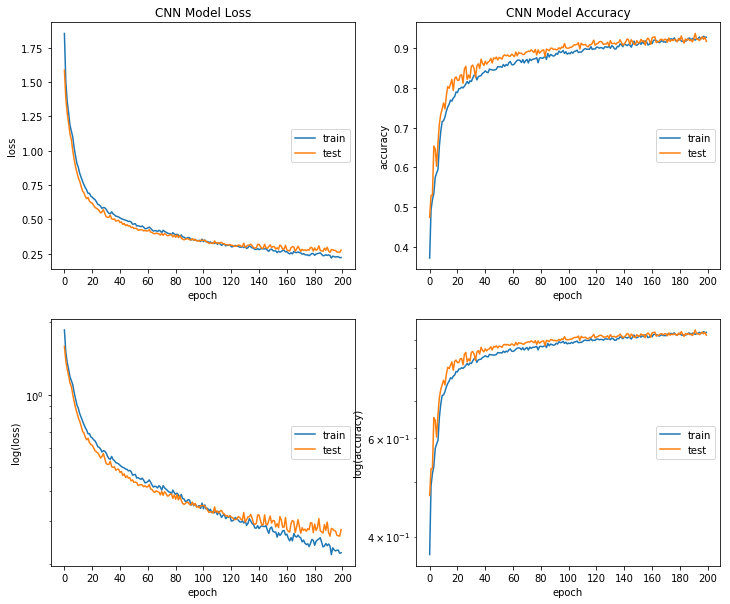

In [615]:
plot_loss_history(CNNmodeln)

In [616]:
cnnn = CNN_Model(cube_stdn_3d.shape[2], filtersize)
cnnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])
CNNmodeln = cnnn.fit({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn, 
                     validation_data=({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn),
                     epochs=60, batch_size=512)

Epoch 1/60
8/8 [==============================] - 0s 61ms/step - loss: 1.8417 - accuracy: 0.3666 - val_loss: 1.5338 - val_accuracy: 0.5112
Epoch 2/60
8/8 [==============================] - 0s 35ms/step - loss: 1.4677 - accuracy: 0.5024 - val_loss: 1.3630 - val_accuracy: 0.4952
Epoch 3/60
8/8 [==============================] - 0s 35ms/step - loss: 1.3296 - accuracy: 0.5236 - val_loss: 1.2524 - val_accuracy: 0.5430
Epoch 4/60
8/8 [==============================] - 0s 37ms/step - loss: 1.2319 - accuracy: 0.5635 - val_loss: 1.1593 - val_accuracy: 0.5717
Epoch 5/60
8/8 [==============================] - 0s 36ms/step - loss: 1.1588 - accuracy: 0.5906 - val_loss: 1.0718 - val_accuracy: 0.7099
Epoch 6/60
8/8 [==============================] - 0s 34ms/step - loss: 1.0823 - accuracy: 0.6259 - val_loss: 1.0207 - val_accuracy: 0.6355
Epoch 7/60
8/8 [==============================] - 0s 34ms/step - loss: 1.0352 - accuracy: 0.6485 - val_loss: 0.9415 - val_accuracy: 0.7173
Epoch 8/60
8/8 [===========

8/8 [==============================] - 0s 33ms/step - loss: 0.4302 - accuracy: 0.8664 - val_loss: 0.4231 - val_accuracy: 0.8874
Epoch 60/60
8/8 [==============================] - 0s 35ms/step - loss: 0.4247 - accuracy: 0.8642 - val_loss: 0.4188 - val_accuracy: 0.8831


In [617]:
# model accuracy on training and testing sets

train_loss, train_acc = cnnn.evaluate({"spectra":cube_trainn2, "spatial":xy_trainn}, cube_train_labelsn)
test_loss, test_acc = cnnn.evaluate({"spectra":cube_testn2, "spatial":xy_testn}, cube_test_labelsn)

print(train_acc, test_acc)

30/30 [==============================] - 0s 4ms/step - loss: 0.4188 - accuracy: 0.8831
0.8846971392631531 0.88310307264328


### Predict pixel classification on north facing image

In [618]:
cube_standardn_1 = cube_standard_north.reshape(cube_standard_north.shape[0], cube_standard_north.shape[1], 1)
print(cube_standardn_1.shape)
xyn_2d = xyn.reshape((xyn.shape[0] * xyn.shape[1]), xyn.shape[2])
print(xyn_2d.shape)

(1995200, 106, 1)
(1995200, 2)


In [619]:
# classify entire binned cube
import time
start_time = time.time()

probCuben = cnnn.predict({"spectra":cube_standardn_1, "spatial":xyn_2d})

elapsed_time = time.time() - start_time
print(time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

00:03:29


In [620]:
predictCuben = probCuben.argmax(axis=-1)

In [621]:
predictCube_reshapen = predictCuben.reshape(cube_sub_north.shape[1], cube_sub_north.shape[2])

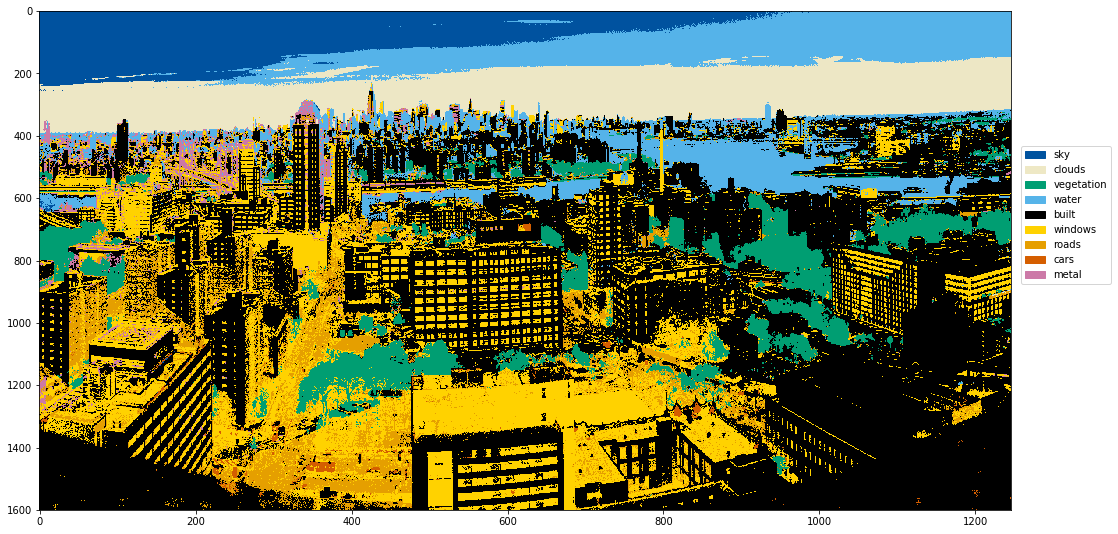

In [622]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0.1,0.1,0.9,0.9])
ax.tick_params(labelsize=10)
ax.imshow(arrayShow, aspect=0.4)
lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.show()
#fig.savefig("./plots/CNN_change_params_spatial_train_all_5_north_predict_map.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

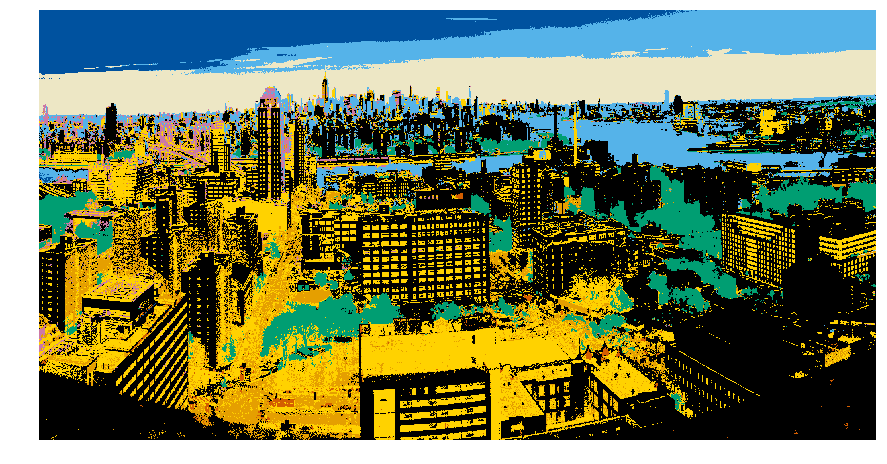

In [623]:
import matplotlib.pyplot as plt
import matplotlib.colors as ListedColorMap
import matplotlib.patches as mpatches
from matplotlib.ticker import NullFormatter
%matplotlib inline

cmap = {0:[0,0.32549,0.62353,1], 1:[0.93333,0.9098,0.77255,1], 2:[0,0.61961,0.45098,1],  3:[0.33725,0.70588,0.91373,1],
        4:[0,0,0,1], 5:[1,0.82353,0,1], 6:[0.90196,0.62353,0,1], 7:[0.83529,0.36863,0,1],
        8:[0.8,0.47451,0.65490,1]}
labels = {0:'sky', 1:'clouds', 2:'vegetation', 3:'water', 4:'built',
          5:'windows', 6:'roads', 7:'cars', 8:'metal'}
arrayShow = np.array([[cmap[i] for i in j] for j in predictCube_reshapen])
patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]

fig = plt.figure(figsize=(15,15))
#ax = fig.add_axes([0.1,0.1,0.9,0.9])
#ax.tick_params(labelsize=10)
plt.imshow(arrayShow, aspect=0.4)
#lgd = ax.legend(handles=patches, bbox_to_anchor=(1,0.75), loc='upper left', borderaxespad=1.0, prop={'size':10}, ncol=1)
plt.axis('off')
plt.show()
fig.savefig("./plots/CNN_Model2_spatial_train_north_binned_{0}_test_north_predict_map.png".format(num_of_bins),
            bbox_inches='tight', dpi=300)

In [624]:
import pickle
pickle.dump(predictCube_reshapen,
            open("./plots/CNN_Model2_spatial_train_north_binned_{0}_test_north_predict_map.pickle".format(num_of_bins),
                 "wb"))

### Evaluation Metrics (north facing)

In [625]:
labelsn_pred_sky = predictCube_reshapen[sky_coordsn[sky_test_indn[:], 0], sky_coordsn[sky_test_indn[:], 1]]
labelsn_pred_clouds = predictCube_reshapen[clouds_coordsn[clouds_test_indn[:], 0], clouds_coordsn[clouds_test_indn[:],1]]
labelsn_pred_veg = predictCube_reshapen[veg_coordsn[veg_test_indn[:],0], veg_coordsn[veg_test_indn[:],1]]
labelsn_pred_wtr = predictCube_reshapen[wtr_coordsn[wtr_test_indn[:],0], wtr_coordsn[wtr_test_indn[:],1]]
labelsn_pred_blt = predictCube_reshapen[blt_coordsn[blt_test_indn[:],0], blt_coordsn[blt_test_indn[:],1]]
labelsn_pred_windows = predictCube_reshapen[windows_coordsn[windows_test_indn[:],0], windows_coordsn[windows_test_indn[:],1]]
labelsn_pred_rds = predictCube_reshapen[rds_coordsn[rds_test_indn[:],0], rds_coordsn[rds_test_indn[:],1]]
labelsn_pred_cars = predictCube_reshapen[cars_coordsn[cars_test_indn[:],0], cars_coordsn[cars_test_indn[:],1]]
labelsn_pred_mtl = predictCube_reshapen[mtl_coordsn[mtl_test_indn[:],0], mtl_coordsn[mtl_test_indn[:],1]]

labelsn_pred = np.concatenate((labelsn_pred_sky, labelsn_pred_clouds, labelsn_pred_veg, labelsn_pred_wtr, 
                             labelsn_pred_blt, labelsn_pred_windows, labelsn_pred_rds, labelsn_pred_cars, labelsn_pred_mtl))

In [626]:
labelsn_true_sky = np.full(len(sky_test_indn), 0)
labelsn_true_clouds = np.full(len(clouds_test_indn), 1)
labelsn_true_veg = np.full(len(veg_test_indn), 2)
labelsn_true_wtr = np.full(len(wtr_test_indn), 3)
labelsn_true_blt = np.full(len(blt_test_indn), 4)
labelsn_true_windows = np.full(len(windows_test_indn), 5)
labelsn_true_rds = np.full(len(rds_test_indn), 6)
labelsn_true_cars = np.full(len(cars_test_indn), 7)
labelsn_true_mtl = np.full(len(mtl_test_indn), 8)

labelsn_true = np.concatenate((labelsn_true_sky, labelsn_true_clouds, labelsn_true_veg, labelsn_true_wtr, 
                             labelsn_true_blt, labelsn_true_windows, labelsn_true_rds, labelsn_true_cars, labelsn_true_mtl))

In [627]:
print(labelsn_pred.shape)
print(labelsn_true.shape)

(941,)
(941,)


In [628]:
from sklearn import metrics

print("Confusion Matrix")
print(metrics.confusion_matrix(labelsn_true, labelsn_pred))

print("")
print("Accuracy Score")
print(metrics.accuracy_score(labelsn_true, labelsn_pred))

target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
print("")
print("Classification Report")
print(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))

Confusion Matrix
[[ 60   0   0   0   0   0   0   0   0]
 [  0  40   0   0   0   0   0   0   0]
 [  0   0 139   0   0   0   1   0   0]
 [  0   0   0 117   1   1   0   0   5]
 [  0   0   0   0 308  11   1   0   0]
 [  0   0   0   0  11 104   4   0   1]
 [  0   0   1   0   8  10  29   0   2]
 [  0   0   0   0  14  11   1  24   0]
 [  0   0   0   2  13  10   2   0  10]]

Accuracy Score
0.8831030818278427

Classification Report
             precision    recall  f1-score   support

        sky       1.00      1.00      1.00        60
     clouds       1.00      1.00      1.00        40
 vegetation       0.99      0.99      0.99       140
      water       0.98      0.94      0.96       124
      built       0.87      0.96      0.91       320
    windows       0.71      0.87      0.78       120
      roads       0.76      0.58      0.66        50
       cars       1.00      0.48      0.65        50
      metal       0.56      0.27      0.36        37

avg / total       0.88      0.88      0.8

In [629]:
f = open("./metrics/CNN_Model2_spatial_train_north_binned_{0}_test_north_metrics.txt".format(num_of_bins), "w")
f.write("Confusion Matrix")
f.write('\n')
f.write(str(metrics.confusion_matrix(labelsn_true, labelsn_pred)))
f.write('\n')
f.write('\n')
f.write("Accuracy Score")
f.write('\n')
f.write(str(metrics.accuracy_score(labelsn_true, labelsn_pred)))
target_names = ['sky', 'clouds', 'vegetation', 'water', 'built', 'windows', 'roads', 'cars', 'metal']
f.write('\n')
f.write('\n')
f.write("Classification Report")
f.write('\n')
f.write(metrics.classification_report(labelsn_true, labelsn_pred, target_names=target_names))
f.close()

In [630]:
print(num_of_bins, filtersize)

106 6
